### <a href=#1>1.Для реализованной в методичке модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.</a>

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import model_selection
import matplotlib.pyplot as plt
import time
import numpy as np

Используем один из "игрушечных" датасетов из той же библиотеки.

In [ ]:
from sklearn.datasets import load_diabetes

In [ ]:
X, y = load_diabetes(return_X_y=True)

Разделим выборку на обучающую и тестовую в соотношении 75/25.

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

Напишем функцию, реализующую предсказание в градиентном бустинге.

In [ ]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функцию.

In [ ]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

Используем $L_{2}$ loss $L(y, z) = (y-z)^{2},$ ее производная по $z$ примет вид $L'(y, z) = 2(z-y)$. Реализуем ее также в виде функции (коэффициент 2 можно отбросить).

In [ ]:
def bias(y, z):
    return (y - z)

Реализуем функцию обучения градиентного бустинга.

In [ ]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

Теперь обучим несколько моделей с разными параметрами и исследуем их поведение.

In [ ]:
# Число деревьев в ансамбле
n_trees = 10

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [ ]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    train_prediction = gb_predict(X_train, trees, coefs, eta)
    
    test_prediction = gb_predict(X_test, trees, coefs, eta)
    mean_squared_error_y_train = mean_squared_error(y_train, train_prediction)
    mean_squared_error_y_test = mean_squared_error(y_test, test_prediction)
    
#     print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
#     с шагом {eta} на тренировочной выборке: {mean_squared_error_y_train}')    

#     print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
#     с шагом {eta} на тестовой выборке: {mean_squared_error_y_test}')
    
    return {"mean_squared_error_y_train":mean_squared_error_y_train,"mean_squared_error_y_test":mean_squared_error_y_test}


Построим графики зависимости ошибки на обучающей и тестовой выборках от числа итераций.

In [ ]:
def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

In [ ]:
get_error_plot(n_trees, train_errors, test_errors, xlabel="Iteration number",ylabel="MSE")

Такой результат не является удовлетворительным

__<div id=1>Построим график</div>__

In [ ]:
def dependence_of_error_on_tree_depth(n_trees, max_depth, X_train, X_test, y_train, y_test, eta=0.1):
   
    error_y_train = np.array([])
    error_y_test = np.array([])
    items = np.array([])
    if type(max_depth) == type(1) and type(n_trees) == type(1):
        max_depth = np.array([max_depth])
          
    
    if type(n_trees) == type(np.array([])):
        items = n_trees
        
        for n_trees_item in n_trees:
            print(n_trees_item, max_depth)
            coefs=[1] * n_trees_item
            trees, train_errors, test_errors = gb_fit(n_trees_item, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
            error = evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)
                      
            error_y_train = np.append(error_y_train, error['mean_squared_error_y_train'])
            error_y_test = np.append(error_y_test, error['mean_squared_error_y_test']) 

   

    elif type(max_depth) == type(np.array([])): 
        items = max_depth
        coefs=[1] * n_trees
        for max_depth_item in max_depth:
            trees, train_errors, test_errors = gb_fit(n_trees, max_depth_item, X_train, X_test, y_train, y_test, coefs, eta)
            error = evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

            error_y_train = np.append(error_y_train, error['mean_squared_error_y_train'])
            error_y_test = np.append(error_y_test, error['mean_squared_error_y_test']) 

        
    return np.array([items,error_y_train,error_y_test])

In [ ]:
def get_error_plot(trees, train_err, test_err,xlabel="",ylabel="" ):
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(min(trees), max(trees))
    plt.plot(list(trees), train_err, label='train error')
    plt.plot(list(trees), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

In [ ]:
start_time = time.clock()
n_trees = np.array(range(10,130,10))
max_depth=2
res = dependence_of_error_on_tree_depth(n_trees,max_depth, X_train, X_test, y_train, y_test)    
res
print("--- %s seconds ---" % (time.clock() - start_time))

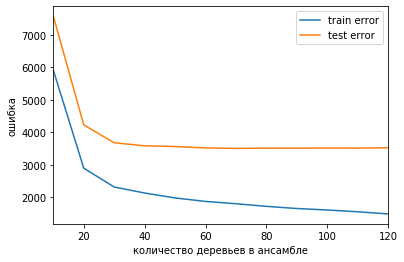

In [59]:
get_error_plot(res[0],res[1],res[2],"количество деревьев в ансамбле", "ошибка")

In [ ]:
start_time = time.clock()
max_depth = np.array(range(1,20))
n_trees=50
res2 = dependence_of_error_on_tree_depth(n_trees,max_depth, X_train, X_test, y_train, y_test)    
res2
print("--- %s seconds ---" % (time.clock() - start_time))

D:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


D:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Attempting to set identical left == right == 1.0 results in singular transformations; automatically expanding.
  after removing the cwd from sys.path.


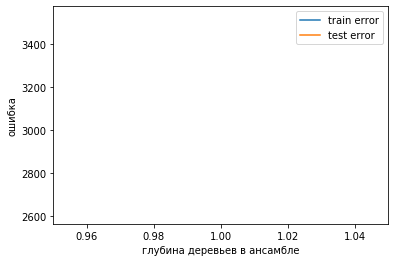

In [61]:
get_error_plot(res2[0],res2[1],res2[2],"глубина деревьев в ансамбле", "ошибка")

__Вывод:__

Оба графика показывают, что с увеличением количества деревьев в ансамбле и глубины деревьев, модель переобучается, так как на train данных ошибка стремится к нулю, а на test данных ошибка увеличивается. Так же из графика зависимости ошибки от глубины дерева, видно, что с ростом глубины переобучение наступает быстрей, чем в случае с количеством деревьев в ансамбле.